# Definições


In [1]:
import numpy as np

np.random.seed(42)
trials = 100000

barris_anual = (
    np.array(
        [
            0,
            6518,
            24144,
            21364,
            18076,
            14772,
            12225,
            10082,
            8338,
            6914,
            6100,
            5436,
            4786,
            4314,
            3928,
            3606,
            3331,
            3093,
            2887,
            2935,
        ]
    )
    * 365
    * 0.158987
)

gas_anual = (
    np.array(
        [
            0,
            0.619,
            2.19,
            1.865,
            1.565,
            1.194,
            0.972,
            0.801,
            0.654,
            0.534,
            0.47,
            0.417,
            0.365,
            0.328,
            0.298,
            0.273,
            0.252,
            0.233,
            0.217,
            0.227,
        ]
    )
    * 1000000
    * 365
)


def investimento_inicial():
    capex = 1640169309.65
    return capex + capex * np.random.uniform(-0.1, 0.1)


def preço_dólar(ano: int):
    a = np.random.uniform(-0.1, 0.3)
    return a * ano + 6


def preço_barril(ano: int):
    return -0.25 * (ano**2) + 5.5 * ano + 70.0001


def preço_gas(ano: int):
    return (17 / 26.8) * preço_dólar(ano)


def fluxo_anual(ano: int):
    # Custos anuais
    opex = (
        475738819.93
        + 53574191.43
        + 66324849.01
        + 202114141.38
        + 26420149.20
        + 133935478.58
    )

    opex = opex + opex * np.random.uniform(-0.1, 0.1)

    # Faturamento anual
    produção = barris_anual[ano] * preço_barril(ano) + gas_anual[ano] * preço_gas(ano)
    faturamento = produção + produção * np.random.normal(0, 0.1)

    return max(faturamento, 0) - opex


anos_de_operação = 20
valor_residual = -300000000
taxa_de_desconto = 0.15


# Simulação


In [2]:
def calcular_fluxos_caixa():
    return [-investimento_inicial()] + [fluxo_anual(i) for i in range(anos_de_operação)]


simulações_fluxos = [calcular_fluxos_caixa() for _ in range(trials)]
fluxos_media = np.mean(simulações_fluxos, axis=0)


# Métricas


## Retorno sobre Investimento (ROI)


Em média, o ROI do projeto é 29.45%


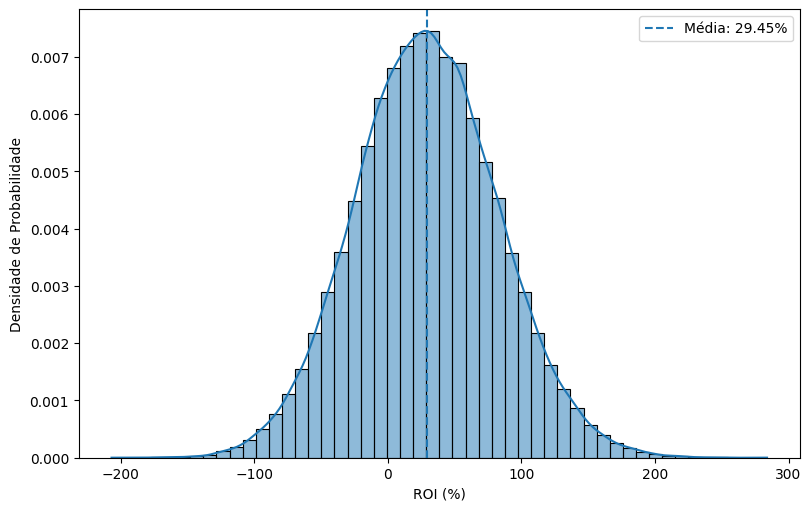

In [3]:
from plots import plot_density


def calcular_roi(fluxos_caixa):
    investimento = -fluxos_caixa[0]
    retorno = np.sum(fluxos_caixa) + valor_residual

    return (retorno / investimento) * 100


roi_values = [calcular_roi(simulações_fluxos[i]) for i in range(trials)]
print(f"Em média, o ROI do projeto é {np.mean(roi_values):.2f}%")

plot_density(roi_values, "ROI", "%")


## Valor Presente Líquido (VPL)


Em média, o VPL do projeto é R$787035484.89


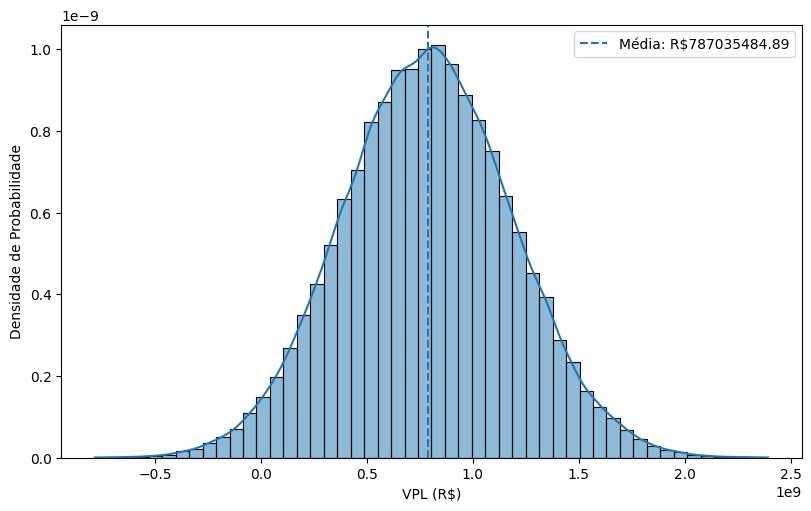

In [4]:
def calcular_vpl(taxa_desconto, fluxos_caixa):
    vpl = 0
    for t, fc in enumerate(fluxos_caixa):
        vpl += fc / (1 + taxa_desconto) ** t
    return vpl + valor_residual


vpl_values = [
    calcular_vpl(taxa_de_desconto, simulações_fluxos[i]) for i in range(trials)
]


print(f"Em média, o VPL do projeto é R${np.mean(vpl_values):.2f}")
plot_density(vpl_values, "VPL", "R$", True)


## TIR (Taxa Interna de Retorno)


In [5]:
from scipy.optimize import root

tir = root(calcular_vpl, x0=0.1, args=(fluxos_media,)).x[0]

print(
    f"Considerando o fluxo de caixa sendo a média de todas as simulações, o TIR do projeto é {tir*100:.2f}%"
)
print(
    f"Com essa taxa de desconto, o valor do VPL é: R${calcular_vpl(tir, fluxos_media):.2f}"
)


Considerando o fluxo de caixa sendo a média de todas as simulações, o TIR do projeto é 24.70%
Com essa taxa de desconto, o valor do VPL é: R$0.00


## Payback


Projeto sem payback
Em média, o payback do projeto é 4.44 anos


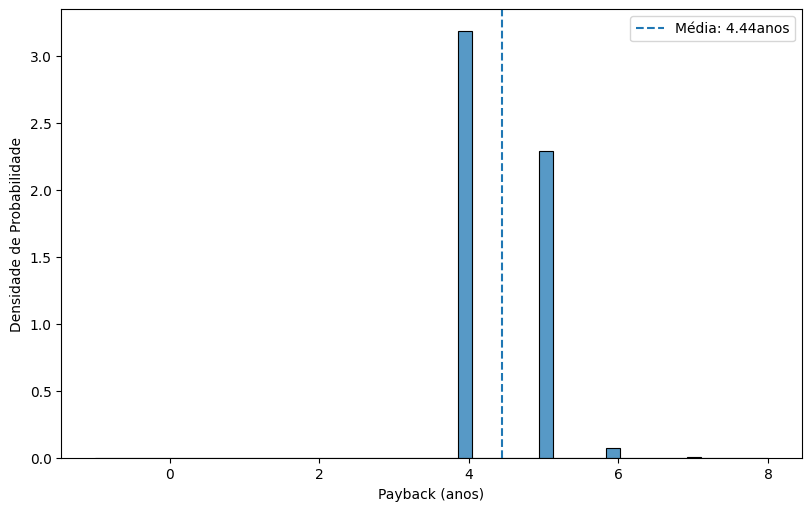

In [6]:
def calcular_payback(taxa_desconto, fluxos_caixa):
    vpl = 0
    for t, fc in enumerate(fluxos_caixa):
        vpl += fc / (1 + taxa_desconto) ** t
        if vpl >= 0:
            return t

    print("Projeto sem payback")
    return -1


payback_values = [
    calcular_payback(taxa_de_desconto, simulações_fluxos[i]) for i in range(trials)
]

print(f"Em média, o payback do projeto é {np.mean(payback_values):.2f} anos")
plot_density(payback_values, "Payback", "anos", kde=False)
